# COXTABL - Extension of the STABL algorithm 


In this notebook we will introduce the extension of the STABL algorithm to the Cox Proportional Hazard model. 

## Data preparation:

Plug your own data here. At the end of this section you should have two variables defined:
- `survival_df` - the table with the information about event (e.g., death), time to event (e.g., survival time), and features for the Cox model. Be sure that there are no NA values in this table.
- `BASE_SURVIVAL_COLUMNS` - the table with the Cox features used in the analysis.

Below we implemented the code th generate random features and survival times:

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import expon

def generate_survival_data(
    n_samples=1000, 
    n_features=20, 
    censoring_rate=0.3, 
    random_state=42, 
    informative_ratio=0.3,
):
    """
    Generate random survival data for Cox regression analysis.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_features : int
        Number of features/covariates
    censoring_rate : float
        Approximate censoring rate (between 0 and 1)
    random_state : int
        Random seed for reproducibility
    informative_ratio: float 
        What percentage of features should be informative.
        
    Returns:
    --------
    DataFrame with survival data and true coefficients
    """
    
    # Set random seed
    np.random.seed(random_state)
    
    # Generate random features (covariates)
    X = np.random.normal(0, 1, size=(n_samples, n_features))
    
    # Generate true coefficients (some positive, some negative, some zero)
    true_coef = np.zeros(n_features)
    n_informative = int(n_features * informative_ratio)
    true_coef[:n_informative] = np.random.uniform(-1, 1, size=n_informative)
    
    # Calculate linear predictor
    linear_pred = np.dot(X, true_coef)
    
    # Generate survival times using exponential distribution
    baseline_hazard = 0.1
    lambda_i = baseline_hazard * np.exp(linear_pred)
    true_times = expon.rvs(scale=1/lambda_i)
    
    # Generate censoring times
    censoring_times = expon.rvs(scale=1/baseline_hazard * 1/censoring_rate, size=n_samples)
    
    # Get observed times and event indicators
    observed_times = np.minimum(true_times, censoring_times)
    event = (true_times <= censoring_times).astype(int)
    
    # Create feature names
    feature_names = [f'X{i+1}' for i in range(n_features)]
    
    # Create DataFrame
    data = pd.DataFrame(X, columns=feature_names)
    
    # Add some categorical variables
    data['sex'] = np.random.binomial(1, 0.5, size=n_samples)
    
    data['days_to_death'] = observed_times
    data['death'] = event
    
    # Create dictionary with true coefficients
    true_coef_dict = dict(zip(feature_names, true_coef))
    
    return data, true_coef_dict

# Generate example dataset
np.random.seed(42)
survival_df, true_coef = generate_survival_data(n_samples=200, n_features=10, censoring_rate=0.3)

In [2]:
# True Coefficients:
true_coef

{'X1': -0.18578702174874473,
 'X2': -0.8679803117195168,
 'X3': -0.30235893206104136,
 'X4': 0.0,
 'X5': 0.0,
 'X6': 0.0,
 'X7': 0.0,
 'X8': 0.0,
 'X9': 0.0,
 'X10': 0.0}

In [3]:
BASE_SURVIVAL_COLUMNS = list(survival_df.columns[:11])

## Running COXTABL on the df.

In this section we will run a lasso version of the COXTABL with artificial features created by permuting the original features. The main function used is `coxtabl.lasso_coxtabl_on_df` with parameters:
- `df` - dataframe with survival data,
- `event_col: str = 'death'` column with the event indicator,
- `duration_col: str = 'days_to_death'` time to event data,
- `data_cols: Optional[list]` name of the features to be used by the Cox model (by default all features, except `event_col` and `duration_col` are used,
- `l1s_to_check: Optional[list]` values of the L1 ratio used - by default `numpy.logspace(-1, -1.5, 10)` is used,
- `l2: float = 0.1` - value for the L2 regularization to impose the numerical stability,
- `iters: int = 100` - number of bootstrap iterations (minimal - 100, optimal > 1000)
- `bootstrap_sample: float = 0.5` - percentage of examples used for a single bootstrap iteration,
- `random_seed: int = 42` - random state for reproducibility,
- `standardize: bool = True` - flag that indicates if data fed to the Cox model is normally standardized,
- `permuted_prefix: str = 'ART'` - prefix of the artificially permuted columns,
- `cox_kwargs: Optional[dict] = None` - additional parameters fed to the `lifelines.CoxPHFitter` object constructor,
- `fit_kwargs: Optional[dict] = None` - additional parameters fed to the `lifelines.CoxPHFitter`  fit method.

It returns a named tuple `LassoCOXTABLResult` with fields:
- `CoxPHFitters` - all `lifelines.CoxPHFFitter` objects used in the experiment,
- `l1_to_names_to_coefs` - mapping from l1 values to values of the coefficients for every feature. E.g. `result.l1_to_names_to_coefs[0.1][feature]` will return values of the learned coefficients for `feature` obtained in training with `0.1` L1 rate,
- `data_cols` - feature names used in the experiment,
- `artificial_cols` - names of the artificially created features.

In [4]:
from coxtabl import coxtabl
import importlib

importlib.reload(coxtabl)


lasso_result = coxtabl.lasso_coxtabl_on_df(
    survival_df, 
    data_cols=BASE_SURVIVAL_COLUMNS,
    lambdas=10,
    standardize=False,
    iters=100,
)

/raid/immucan/immuw/COXTABL/coxtabl/coxtabl.py:262: RuntimeWarning: divide by zero encountered in divide
  inv_r_powers_for_events = 1 / r_powers_for_events
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:46<00:00,  2.27s/it]


## Computation of the F-acceptance matrix.

Part of the `STABL` algorithm is computation of the non-zero parameter percentage for different values of regularization. You can use `coxtabl.compute_acceptance_per_l1_df` function that accepts as its input:
- `result: LassoCOXTABLResult` - result of a `coxtabl.lasso_coxtabl_on_df` function,
- `threshold: float = 0.01` - coefficients with absolute value smaller than `threshold` are treated as zero-valued coefficients. 

One can use `coxtabl.plot_acceptance_matrix` to plot the acceptance matrix in a digestible format.

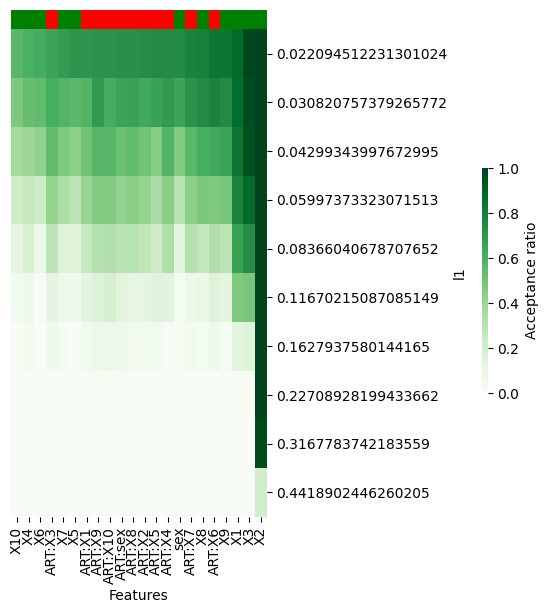

In [5]:
acceptance_per_l1_df = coxtabl.compute_acceptance_per_l1_df(lasso_result, threshold=0.01)
coxtabl.plot_acceptance_matrix(acceptance_per_l1_df)

## Feature selection.

Acceptance matrix is used for a final feature selection. It is performed using `coxtabl.feature_selection` method.

It returns a named tuple `FeatureSelectionResult` with,
- `thresholds` - thresholds used in the analysis,
- `fdps` - FDPs computed as a part of STABL algorithm,
- `threshold` - threshold for a minimal FDP,
- `selected_features` - list of a finally selected features.

In [6]:
feature_selection_result = coxtabl.feature_selection(
    acceptance_per_l1_df,
    data_cols=lasso_result.data_cols,
    artificial_cols=lasso_result.artificial_cols,
)

feature_selection_result.selected_features

['X1', 'X3', 'X2']

One can use a handy `coxtable.plot_feature_selection_result` function to visualize results:

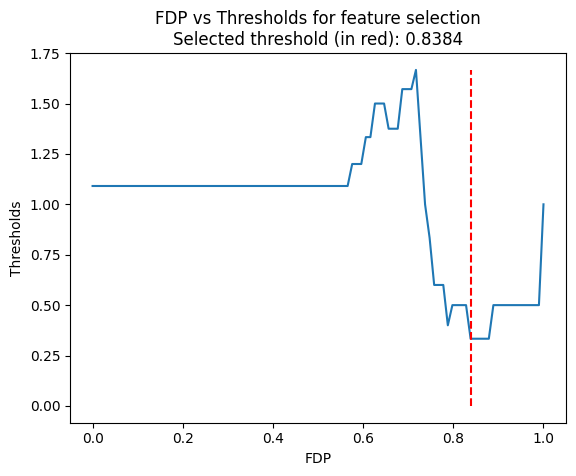

In [7]:
coxtabl.plot_feature_selection_result(feature_selection_result, )

Now - let's use the selected features to fit the final Cox model and compare results with ground truth coefficients:

<Axes: xlabel='log(HR) (95% CI)'>

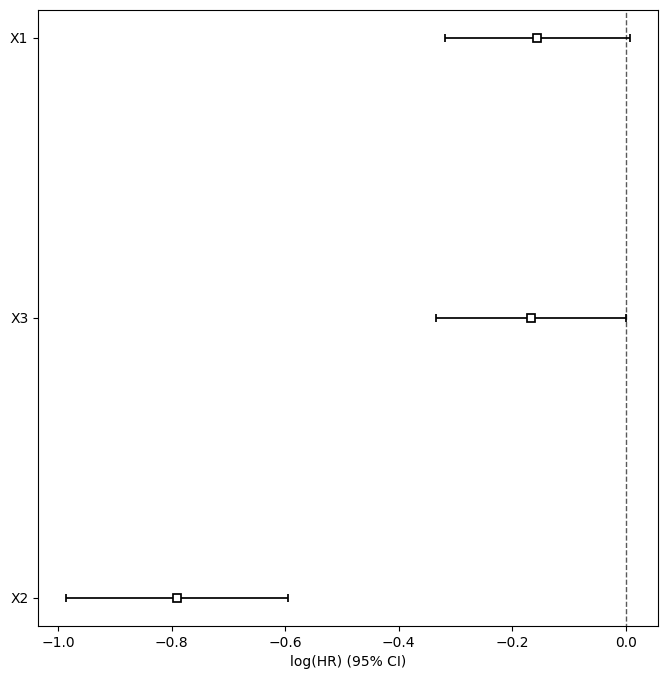

In [8]:
import matplotlib.pyplot as plt


FINAL_DATA_COLUMS = feature_selection_result.selected_features
ALL_FEATURES = FINAL_DATA_COLUMS + ['death', 'days_to_death']

from sklearn.preprocessing import StandardScaler

cox_sc = StandardScaler()
cox_data = survival_df[ALL_FEATURES].copy()
cox_data[FINAL_DATA_COLUMS] = cox_sc.fit_transform(
    cox_data[FINAL_DATA_COLUMS].values
)

from lifelines import CoxPHFitter

final_cphf = CoxPHFitter(penalizer=0.01)

final_cphf.fit(cox_data, event_col='death', duration_col='days_to_death')

plt.figure(figsize=(8, 8))
final_cphf.plot()